<a href="https://colab.research.google.com/github/mobarakol/PitVQA/blob/main/PitVQANet_endo18_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Download code
!git clone https://github.com/HRL-Mike/PitVQA.git

#Download Dataset
!mkdir /content/PitVQA/datasets
%cd /content/PitVQA/datasets
!gdown --id 1FoAEY_u0PTAlrscjEifi2om15A83wL78

# Unzipping the VQA EndoVis18 Dataset
!unzip -q EndoVis-18-VQA.zip
%cd /content/PitVQA

Cloning into 'PitVQA'...
remote: Enumerating objects: 126, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (120/120), done.
remote: Total 126 (delta 41), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (126/126), 139.64 KiB | 6.65 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/PitVQA/datasets
/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1FoAEY_u0PTAlrscjEifi2om15A83wL78
From (redirected): https://drive.google.com/uc?id=1FoAEY_u0PTAlrscjEifi2om15A83wL78&confirm=t&uuid=247040f9-4fd0-4a41-ba7a-3e543925e00e
To: /content/PitVQA/datasets/EndoVis-18-VQA.zip
100% 2.71G/2.71G [01:42<00:00, 26.4MB/s]
/content/PitVQA


In [ ]:
# download weights
!gdown --id 1yADoQuso2dwnp8gYNPA19dcIE0hHTqR1

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1yADoQuso2dwnp8gYNPA19dcIE0hHTqR1
From (redirected): https://drive.google.com/uc?id=1yADoQuso2dwnp8gYNPA19dcIE0hHTqR1&confirm=t&uuid=e8ea33f1-e1ca-4804-a072-752abb00ae34
To: /content/PitVQA/pitvqa_endo18_weights_3.pth.tar
100% 4.07G/4.07G [04:25<00:00, 15.3MB/s]


In [ ]:
!pip install -q timm==0.9.12 fairscale==0.4.13 scikit-learn==1.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 26.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 56.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 68.7 MB/s eta 0:00:00


### Define functions

In [ ]:
import torch
from dataloader import EndoVis18VQAGPTClassification
from utils import calc_acc, calc_precision_recall_fscore

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from tqdm import tqdm

import os
import sys
import random
import numpy as np
import warnings
warnings.filterwarnings("ignore")


def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


def validate(val_loader, model, criterion, device):
    model.eval()
    total_loss = 0.0
    label_true = None
    label_pred = None

    with torch.no_grad():
        for i, (file_name, images, questions, labels) in enumerate(tqdm(val_loader),0):
            # label
            labels = labels.to(device)

            # model forward pass
            outputs = model(image=images.to(device), question=questions)

            # loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            scores, predicted = torch.max(F.softmax(outputs, dim=1).data, 1)
            label_true = labels.data.cpu() if label_true is None else torch.cat((label_true, labels.data.cpu()), 0)
            label_pred = predicted.data.cpu() if label_pred is None else torch.cat((label_pred, predicted.data.cpu()), 0)

    acc = calc_acc(label_true, label_pred)
    precision, recall, f_score = calc_precision_recall_fscore(label_true, label_pred)
    print(f'\ntest acc: {acc} | test precision: {precision} | test recall: {recall} | test F1: {f_score}')
    return acc, precision, recall, f_score

### Please rename the model.py file to PitVQANet.py

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 40
seed_everything(42)

# preapre model
model_path = 'pitvqa_endo18_weights.pth.tar'
checkpoint = torch.load(model_path, map_location='cpu')
model = checkpoint['model']
model.to(device)
criterion = nn.CrossEntropyLoss().to(device)

# prepare validation set
val_seq = [1, 5, 16]
folder_head = '/content/PitVQA/datasets/EndoVis-18-VQA/seq_'
folder_tail = '/vqa/Classification/*.txt'
val_dataset = EndoVis18VQAGPTClassification(val_seq, folder_head, folder_tail)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

test_acc, test_precision, test_recall, test_f_score = validate(val_loader=val_dataloader, model=model,
                                  criterion=criterion, device=device)

Total files: 447 | Total question: 2769


100%|██████████| 70/70 [02:04<00:00,  1.78s/it]


test acc: 0.6850848681834597 | test precision: 0.5192300183929357 | test recall: 0.4849299259493336 | test F1: 0.6165228081712402


### Balanced Accuracy

In [ ]:
from sklearn.metrics import balanced_accuracy_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 40
seed_everything(42)

# preapre model
model_path = 'pitvqa_endo18_weights.pth.tar'
checkpoint = torch.load(model_path, map_location='cpu')
model = checkpoint['model']
model.to(device)

# prepare validation set
val_seq = [1, 5, 16]
folder_head = '/content/PitVQA/datasets/EndoVis-18-VQA/seq_'
folder_tail = '/vqa/Classification/*.txt'
val_dataset = EndoVis18VQAGPTClassification(val_seq, folder_head, folder_tail)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=8)

# evaluation
label_true = None
label_pred = None
model.eval()
with torch.no_grad():
    for i, (file_name, images, questions, labels) in enumerate(tqdm(val_dataloader),0):
        labels = labels.to(device)
        outputs = model(image=images.to(device), question=questions)

        scores, predicted = torch.max(F.softmax(outputs, dim=1).data, 1)
        if label_true is None:
            label_true = labels.data.cpu()
        else:
            label_true = torch.cat((label_true, labels.data.cpu()), 0)
        if label_pred is None:
            label_pred = predicted.data.cpu()
        else:
            label_pred = torch.cat((label_pred, predicted.data.cpu()), 0)

    score = balanced_accuracy_score(label_true.numpy(), label_pred.numpy())
    print(f'balanced_accuracy_score: {score}')

Total files: 447 | Total question: 2769


100%|██████████| 70/70 [02:02<00:00,  1.74s/it]

balanced_accuracy_score: 0.45059192101262246


### Demo

Downloading...
From: https://drive.google.com/uc?id=1Kg-dwCsKivNKubEPXWmOopuw91v3megC
To: /content/PitVQA/frame052.png
100% 1.44M/1.44M [00:00<00:00, 123MB/s]


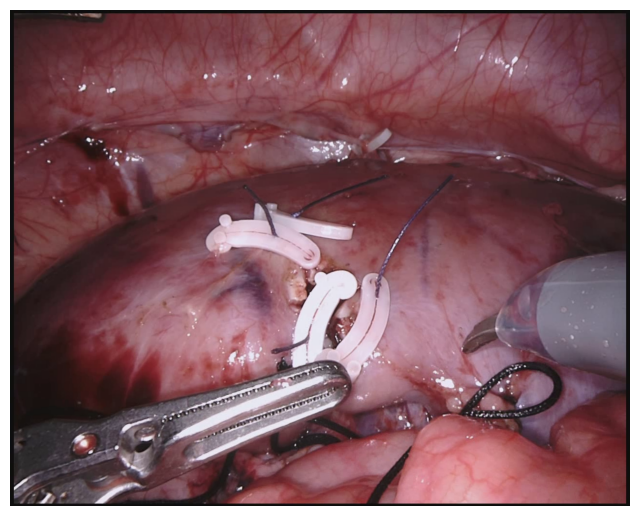

true labels: tensor([ 0,  1, 15])
pred labels: tensor([ 0,  1, 15])
What organ is being operated?
true answer: kidney
pred answer: kidney
What is the state of bipolar_forceps?
true answer: Idle
pred answer: Idle
Where is monopolar_curved_scissors located?
true answer: right-top
pred answer: right-top


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed_everything(42)

# download image
!gdown 1Kg-dwCsKivNKubEPXWmOopuw91v3megC

# process image
transform = transforms.Compose([
       transforms.Resize((224, 224), interpolation=InterpolationMode.BICUBIC),
       transforms.ToTensor(),
       ])
raw_image = Image.open('frame052.png').convert('RGB')
image = transform(raw_image)
images = image.repeat(3, 1, 1, 1) # len(questions)=3

# prepare questions and answers
questions = ['What organ is being operated?',
       'What is the state of bipolar_forceps?',
       'Where is monopolar_curved_scissors located?']
answers = ['kidney',
      'Idle',
      'right-top']

# define labels
labels = ['kidney',
      'Idle', 'Grasping', 'Retraction', 'Tissue_Manipulation',
      'Tool_Manipulation', 'Cutting', 'Cauterization', 'Suction',
      'Looping', 'Suturing', 'Clipping', 'Staple', 'Ultrasound_Sensing',
      'left-top', 'right-top', 'left-bottom', 'right-bottom']
labels_num = []
for i in range(len(answers)):
  labels_num.append(labels.index(answers[i]))
labels_num = torch.tensor(labels_num)

# plot image
plt.figure(figsize=(8, 8))
plt.imshow(raw_image)
plt.axis('off')
plt.show()

# preapre model
model_path = 'pitvqa_endo18_weights.pth.tar'
checkpoint = torch.load(model_path, map_location='cpu')
model = checkpoint['model']
model.to(device)

# inference
label_true = None
label_pred = None
model.eval()
with torch.no_grad():
    labels_num = labels_num.to(device)
    outputs = model(image=images.to(device), question=questions)

    scores, predicted = torch.max(F.softmax(outputs, dim=1).data, 1)
    if label_true is None:
        label_true = labels_num.data.cpu()
    else:
        label_true = torch.cat((label_true, labels_num.data.cpu()), 0)
    if label_pred is None:
        label_pred = predicted.data.cpu()
    else:
        label_pred = torch.cat((label_pred, predicted.data.cpu()), 0)
    print(f'true labels: {label_true}')
    print(f'pred labels: {label_pred}')

print('What organ is being operated?')
print(f'true answer: {labels[label_true[0]]}')
print(f'pred answer: {labels[label_pred[0]]}')
print('What is the state of bipolar_forceps?')
print(f'true answer: {labels[label_true[1]]}')
print(f'pred answer: {labels[label_pred[1]]}')
print('Where is monopolar_curved_scissors located?')
print(f'true answer: {labels[label_true[2]]}')
print(f'pred answer: {labels[label_pred[2]]}')